In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchsummary import summary
from torchvision import datasets
import urllib
import torchmetrics
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassF1Score

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

densenet = torchvision.models.densenet121(pretrained=True)    
for param in densenet.parameters():
    param.requires_grad = False
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 4),
)
densenet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    opt.zero_grad()                    # Flush memory  
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step
    
    return batch_loss.detach().cpu().numpy()

In [33]:
@torch.no_grad()
def accuracy(x, y, model):
  """
  Calculate and return the accuracy. 
  x: features
  y: labels
  Return: accuracy
  """
  model.eval()
  prediction = model(x)
  argmaxes = prediction.argmax(dim=1) # get the predicted label 
  f1 = MulticlassF1Score(num_classes=4,average=None).cuda()
  f1_score = f1(prediction,y)
  auc = MulticlassAUROC(num_classes=4, average=None, thresholds=None).cuda()
  auc_score = auc(prediction,y)
  s = torch.sum((argmaxes == y).float())/len(y)  # calculate test accuracy
  return s.cpu().numpy(),f1_score.cpu().numpy(),auc_score.cpu().numpy()

In [34]:
def plot(losses,accuracies,n_epochs):
  """
  Plot the training accuracies and losses over number of epochs 
  losses: a list of training loss
  accuracies: a list of training accuracy
  n_epochs: a list of number of epochs
  """
  plt.figure(figsize=(13,3))
  plt.subplot(121)
  plt.title('Training Loss over epochs')
  plt.plot(np.arange(n_epochs) + 1, losses)
  plt.subplot(122)
  plt.title('Training Accuracy over epochs')
  plt.plot(np.arange(n_epochs) + 1, accuracies)

In [35]:
def plot_f1_auc(f1,auc,n_epochs):
  """
  Plot the training accuracies and losses over number of epochs 
  losses: a list of training loss
  accuracies: a list of training accuracy
  n_epochs: a list of number of epochs
  """
  fig, axs = plt.subplots(2, 2)
  axs[0, 0].plot(np.arange(n_epochs) + 1, f1[...,0])
  axs[0, 0].set_title('Mild Demented')
  axs[0, 1].plot(np.arange(n_epochs) + 1, f1[...,1])
  axs[0, 1].set_title('Moderate Demented')
  axs[1, 0].plot(np.arange(n_epochs) + 1, f1[...,2])
  axs[1, 0].set_title('Non Demented')
  axs[1, 1].plot(np.arange(n_epochs) + 1, f1[...,3])
  axs[1, 1].set_title('Mild Demented')

  for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='F1 Score')
  
  for ax in axs.flat:
    ax.label_outer()
  
  fig2, axs2 = plt.subplots(2, 2)
  axs2[0, 0].plot(np.arange(n_epochs) + 1, auc[...,0])
  axs2[0, 0].set_title('Mild Demented')
  axs2[0, 1].plot(np.arange(n_epochs) + 1, auc[...,1])
  axs2[0, 1].set_title('Moderate Demented')
  axs2[1, 0].plot(np.arange(n_epochs) + 1, auc[...,2])
  axs2[1, 0].set_title('Non Demented')
  axs2[1, 1].plot(np.arange(n_epochs) + 1,auc[...,3])
  axs2[1, 1].set_title('Mild Demented')

  for ax in axs2.flat:
    ax.set(xlabel='Epoch', ylabel='AUC')
  
  for ax in axs2.flat:
    ax.label_outer()
  plt.plot()

In [36]:
def train(trainset, testset, model, name):
  """
  Train the model with training dataset, and return the training losses, training
    accuracies, and number of epochs. 
  trainset: the processed train data with wanted dimensions
  testset:  the processed test data with wanted dimensions
  model: a torchvision model
  name: the name of the model in string
  Return: Testing accuracy, training losses, training accuracies, and number of epochs
  """
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # load the data
  train_dl = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True,drop_last=True)
  test_dl = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False,drop_last=True)

  # set up loss function and optimization function
  loss_func = nn.CrossEntropyLoss()
  opt = Adam(model.parameters(), lr=1e-3)

  # train and record the loss, accuracies for each training epoch
  losses, accuracies, n_epochs = [], [], 100
  for epoch in range(n_epochs):
    running_vloss = 0.0
    print(f"Running epoch {epoch + 1} of {n_epochs}")
  
    epoch_losses, epoch_accuracies  = [], []
    for batch in train_dl:
      # calculate loss
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, opt, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses)

    for batch in train_dl:
      # calcualte accuracy 
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_acc, _, _ = accuracy(x, y, model)
        epoch_accuracies.append(batch_acc)
    
    epoch_accuracy = np.mean(epoch_accuracies)
    
    
    print(f"The training loss and training accuracy is {epoch_loss} and {epoch_accuracy}")
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

  # calculate the testing accuracy using the model we just trained
  epoch_accuracies = []
  batch_num = 0.0
  f1_batch, auc_batch = 0, 0
  for ix, batch in enumerate(test_dl):
      x, y = batch
      x, y = x.to(device), y.to(device)
      batch_acc, batch_f1, batch_auc = accuracy(x, y, model)
      epoch_accuracies.append(batch_acc)
      f1_batch += batch_f1
      auc_batch += batch_auc
      batch_num += 1
  print(f"batch number is {batch_num}")
  f1_batch=f1_batch/batch_num
  auc_batch=auc_batch/batch_num   
  # save the model for future uses
  torch.save(model.state_dict(), name+".pth")
  print(f"Test accuracy: {np.mean(epoch_accuracies)}")
  return np.mean(epoch_accuracies), losses, accuracies, n_epochs, f1_batch, auc_batch

In [37]:
def main():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  # transform the images to match the ImageNet image requirementa
  transform = transforms.Compose(
      [transforms.Resize((256,256)),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(0.4),
       transforms.RandomVerticalFlip(0.2),
       transforms.RandomAffine(40),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
       ]) 

  # save to data folder
  trainset = torchvision.datasets.ImageFolder(root='data/train',transform=transform)

  testset = torchvision.datasets.ImageFolder(root='data/test',transform=transform)
  # a list of initialized models
  models = [densenet]
  # the names of the models
  names = ["densenet"]

  test_acc = [] # store the testing accuracy
  for model, name in zip(models,names):
    acc, losses , accuracies, n_epochs, f1_score, auc_score = train(trainset,testset,model, name)
    test_acc.append(acc)
    plot(losses, accuracies, n_epochs)
    print(f"f1 scores is {f1_score}")
    print(f"AUC is {auc_score}")
    plt.show()
  
  print(f"The test accuracy is: {test_acc}")


Running epoch 1 of 100
The training loss and training accuracy is 0.9813307523727417 and 0.5728515386581421
Running epoch 2 of 100
The training loss and training accuracy is 0.962415874004364 and 0.589648425579071
Running epoch 3 of 100
The training loss and training accuracy is 0.9730445742607117 and 0.5833984613418579
Running epoch 4 of 100
The training loss and training accuracy is 0.9635316133499146 and 0.593554675579071
Running epoch 5 of 100
The training loss and training accuracy is 0.953774094581604 and 0.592578113079071
Running epoch 6 of 100
The training loss and training accuracy is 0.9471540451049805 and 0.605664074420929
Running epoch 7 of 100
The training loss and training accuracy is 0.9380960464477539 and 0.587890625
Running epoch 8 of 100
The training loss and training accuracy is 0.937939465045929 and 0.5951172113418579
Running epoch 9 of 100
The training loss and training accuracy is 0.9202380180358887 and 0.5962890386581421
Running epoch 10 of 100
The training loss 

/home/valicia/miniconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


batch number is 39.0
Test accuracy: 0.6065705418586731
f1 scores is [0.02146372 0.01025641 0.47585618 0.2034011 ]
AUC is [0.01339147 0.02564103 0.03473945 0.02398676]


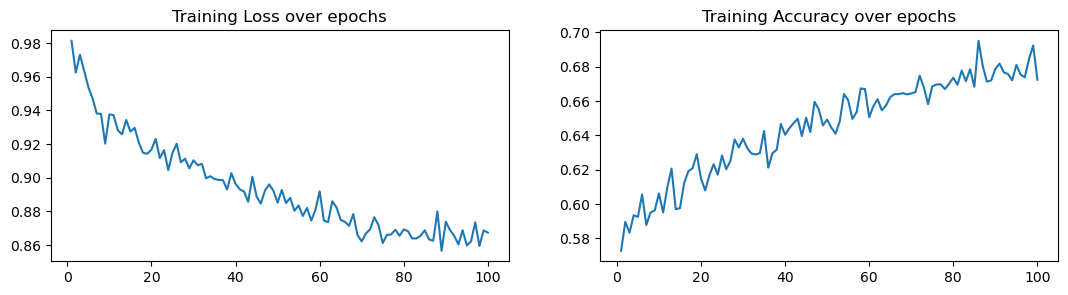

The test accuracy is: [0.60657054]


In [39]:
if __name__ == "__main__":
  main()

Densenet121 testing accuracy after 100 epoch is 0.60657.

f1 scores is [0.02146372 0.01025641 0.47585618 0.2034011 ]

AUC is [0.01339147 0.02564103 0.03473945 0.02398676]

In [33]:
transform_test = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ]) 

testset = torchvision.datasets.ImageFolder(root='data/test',transform=transform_test)

test_dl = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False,drop_last=True)

epoch_accuracies = []
batch_num = 0.0
f1_batch, auc_batch = 0, 0
for ix, batch in enumerate(test_dl):
    x, y = batch
    x, y = x.to(device), y.to(device)
    batch_acc, batch_f1, batch_auc = accuracy(x, y, densenet)
    epoch_accuracies.append(batch_acc)
    f1_batch += batch_f1
    auc_batch += batch_auc
    batch_num += 1
f1_batch=f1_batch/batch_num
auc_batch=auc_batch/batch_num   
print(f"Test accuracy: {np.mean(epoch_accuracies)}")
print(f"f1 scores is {f1_batch}")
print(f"Auc is {auc_batch}")

NameError: name 'accuracy' is not defined

In [8]:
import gc
gc.collect()

1208

In [11]:
transform = transforms.Compose(
      [transforms.Resize((256,256)),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(0.4),
       transforms.RandomVerticalFlip(0.2),
       transforms.RandomAffine(40),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
       ]) 

densenet.load_state_dict(torch.load("densenet.pth"))
densenet.eval()
testset = torchvision.datasets.ImageFolder(root='data/test',transform=transform)
test_dl = torch.utils.data.DataLoader(testset, batch_size=1279,shuffle=False,drop_last=True)
f1_result,auc_result = 0,0
batch_num = 0.0
for ix,batch in enumerate(test_dl):
      x,y = batch
      x,y = x.cuda(),y.cuda()
      prediction = densenet(x)
      f1 = MulticlassF1Score(num_classes=4,average=None).cuda()
      f1_score = f1(prediction,y)
      auc = MulticlassAUROC(num_classes=4, average=None, thresholds=None).cuda()
      auc_score = auc(prediction,y)
      f1_result+=f1_score.cpu().numpy()
      auc_result+=auc_score.cpu().numpy()
      batch_num +=1
print(f"average f1 scores is {f1_result/batch_num}")
print(f"average auc is {auc_result/batch_num}")

RuntimeError: CUDA out of memory. Tried to allocate 3.83 GiB (GPU 0; 11.77 GiB total capacity; 5.33 GiB already allocated; 1.57 GiB free; 8.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF